In [1]:
import numpy as np
#import cupy as np
np.set_printoptions(precision=2)

In [2]:
# data_format='channels_first' in this code the channels are first
#2,3,3 is a 2 channels each one is 3x3 

In [3]:
def relu(v):
    return np.maximum(0,v)

In [4]:
def sigmoid(v):
    return (1 / (1+ np.exp(-v)) )

In [5]:
def clip(x): #clip is getting 
    if x<-1:
        return -1
    elif x>1:
        return 1
    else:
        return x

#### Matrix_dot calculates the wise-element product between two matrices (or cubes)

In [6]:
def Matrix_Dot(W1_,W2_):
    if W1_.shape!=W2_.shape:
        print("Matrices of different sizes")
        return
    if len(W1_.shape) != 3 or len(W2_.shape)!=3:
        print("The matrices must have 3 dimensinons")
        return
    W1_channels, W1_row, W1_col = W1_.shape
    W2_channels, W2_row, W2_col= W2_.shape
    result = np.dot(np.reshape(W1_, W1_channels * W1_row *W1_col) ,np.reshape(W2_, W2_channels *  W2_row*W2_col))  
    return result

#### forward_propagation of a dense layer in neural network

In [7]:
#Forward propagation takes an input X, a matrix representing the coeficiants of neurons, and an activation function
def forward_prop(X,W,fn=sigmoid):
    X_length = X.shape[0] #length of X 
    W_rows,W_cols = W.shape #nb of rows and columns on matrix W    
    if W_rows != X_length:
        print("Not proprtional size")
        return
    output = np.zeros(W_cols)
    for i in range(W_cols): 
        output[i] = fn( (np.dot(X, W[:,i]) )) #the sigmoid of the scalar product of X and column i of W
           
    return output

#### MAxPooling gives a new matrix, with the max pixel of each window determined by the window size

In [8]:
def MaxPooling(W, M, stride =1, padding=0):
    #M is a tuple of diemensions of the maxpooling filter
    W_width, W_row, W_col = W.shape
    f,f = M[0],M[1]
    m = int((W_row +2*padding -f) /stride +1)
    #print(m)
    W_result = np.zeros((W_width, m,m))
    ctr_i = ctr_j = 0
    for w in range(0, W_width, 1): #w of output is same as w of input
        for i in range(0, W_row-f+1, stride): #ncounter on rows
            for j in range(0, W_col-f+1, stride): #counter on columns
                W_temp = W[w, i:i+f, j:j+f]
                r = np.max(W_temp)
                W_result[w, ctr_i, ctr_j] = r
                ctr_j += 1
            ctr_i += 1
            ctr_j = 0
        ctr_i = 0
        ctr_j = 0
    
    #result have width same as input
    return W_result

In [21]:
T = np.random.rand(1,6,6)*100
print("T\n", T)
print("MaxPooling of T:\n", MaxPooling(T,(3,3),stride=3 ))

T
 [[[17.68 63.73 80.86 84.91 23.   65.49]
  [16.7   2.56  9.09 80.4  19.02 24.37]
  [93.77 48.5  24.26 90.92 65.11  3.41]
  [ 0.23 54.18 39.94  6.82 64.78 74.7 ]
  [33.5   5.92 16.98 61.91 97.24 20.68]
  [ 2.67  3.44  7.01 39.48 58.6  36.71]]]
MaxPooling of T:
 [[[93.77 90.92]
  [54.18 97.24]]]


In [10]:
def AvgPooling(W, M, stride =1, padding=0):
    #M is a tuple of diemensionAvgPoolingof the maxpooling filter
    W_width, W_row, W_col = W.shape
    f,f = M[0],M[1]
    m = int((W_row +2*padding -f) /stride +1)
    print(m)
    W_result = np.zeros((W_width, m,m))
    ctr_i = ctr_j = 0
    for w in range(0, W_width, 1): #w of output is same as w of input
        for i in range(0,W_row-f+1, stride): #ncounter on rows
            for j in range(0,W_col-f+1, stride): #counter on columns
                W_temp = W[w, i:i+f, j:j+f]
                r = np.average(W_temp)
                W_result[w,ctr_i, ctr_j] = r
                ctr_j += 1
            ctr_i += 1
            ctr_j = 0
        ctr_i=0
        ctr_j=0
    return W_result

In [23]:
T2 = np.random.rand(1,9,9)*100
print("T2\n", T2)
print("Average Pooling of T2:\n", AvgPooling(T2,(3,3),stride=3 ))

T2
 [[[22.32 64.95 43.2   6.3  97.01 75.13 40.57 41.79  4.74]
  [74.47 16.4  27.85 94.85 28.47 59.94 67.26 53.22 63.16]
  [57.7  32.76 82.1  29.01 96.93 51.57 70.21 60.3  71.87]
  [26.4  31.15 89.3  50.77 75.22 44.43 14.72 54.38 13.96]
  [75.99  1.55 16.01  2.25  9.39 97.72 83.52 71.13 13.69]
  [16.17 38.57 15.65 21.66 11.   18.12 80.91 96.74 45.  ]
  [70.09 39.81 15.84 43.59 48.85 66.84 68.31 75.76 79.42]
  [18.86 95.68 84.05 53.33 29.79 59.36 80.   37.34  6.14]
  [60.08 20.76 61.46 25.11 84.28 53.73 66.34 89.6  83.31]]]
3
Average Pooling of T2:
 [[[46.86 59.91 52.57]
  [34.53 36.73 52.67]
  [51.85 51.65 65.13]]]


##### Conv2d takes a cube as as input, a cube as a filer having same nb of channels as input, stride, padding, an activation function, and print_details 

In [11]:
def Conv2d(W_, Filters, Bias,  stride=1,padding=0, fn=relu, print_details=False ):
    #Filters is a cube of filters
    #Bias is a list ob biases eachone for a Filter
    W_chan, W_r,W_col = W_.shape
    Filter_num, F_c, F,F = Filters.shape #4 dimension matrix, the first element in shape is the nb of cube filters
    
    if(W_chan != F_c):
        print("The number of channels for matrix and filter must be the same")
        return
    
    dim =  int ((W_r + 2*padding - F) /stride + 1) # the new dimension of the output after padding and stride of the filter channels
    
    if padding!=0: #create the output cube and fill with zeros
        W_new = np.zeros((W_chan, W_r + 2*padding, W_r + 2*padding))
        W_new[:W_chan, 1*padding:-1*padding, 1*padding:-1*padding] = W_ #Add zeros around W_ and keep the rest as it is
        if print_details:
            print("W2 with padding:\n" , W_new)
            print("Filters:\n" , Filters)
    else:
        W_new=W_
        if print_details:
            print("W2 without padding:\n" , W_new)
            print("Filters:\n", Filters)
    w_chan, w_row,w_col = W_new.shape
    Result_Matrix = np.zeros((Filter_num, dim,dim)) 
    print("Dimensions of output of Conv:", Filter_num , dim, dim)
    
    for f in range(Filter_num):
        ctr_i = ctr_j = 0
        for i in range(0, w_row-F+1, stride): #From , To, By
            for j in range ( 0, w_col-F+1, stride):
                W_temp = W_new[:,i:i+F, j:j+F]
                Result_Matrix[f, ctr_i, ctr_j] = fn(Matrix_Dot(W_temp, Filters[f]) + Bias[f] )
                ctr_j += 1
            ctr_j = 0
            ctr_i += 1
    return Result_Matrix

In [12]:
#With padding
W1 = np.random.rand(3,4,4)
Filters = np.random.rand(2,3,3,3)
#Bias = np.random.rand(Filters.shape[0])
Bias = np.array([1,1])
print(Conv2d(W1,Filters, Bias, 1,1,sigmoid, print_details=False))

Dimensions of output of Conv: 2 4 4
[[[0.98 0.99 0.99 0.96]
  [0.99 1.   1.   0.98]
  [0.99 1.   1.   0.97]
  [0.97 0.98 0.99 0.93]]

 [[0.99 0.99 1.   0.96]
  [0.99 1.   1.   0.98]
  [0.99 1.   1.   0.98]
  [0.97 0.99 0.99 0.91]]]


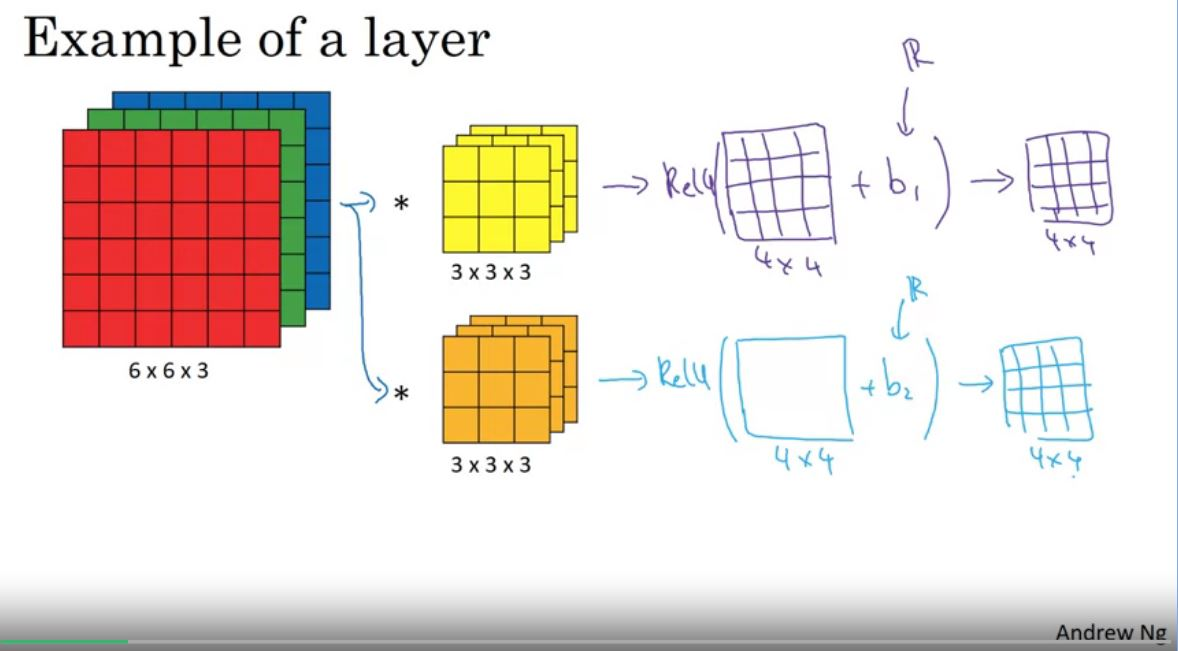

In [13]:
#With padding
W1 = np.random.rand(3,7,7)
Filters = np.random.rand(2,3,3,3)
Bias = np.random.rand(Filters.shape[0])

print(Conv2d(W1,Filters, Bias, 3,1, fn=relu, print_details=False))

Dimensions of output of Conv: 2 3 3
[[[3.68 5.93 2.61]
  [5.34 6.57 5.19]
  [4.28 6.12 2.98]]

 [[4.31 7.45 3.4 ]
  [6.99 8.24 7.47]
  [4.48 6.72 3.5 ]]]


In [14]:
W0 = np.random.rand(3, 128, 128)

In [15]:
#Conv(W_, Filters, Bias,  stride=1,padding=0, fn=relu, print_details=False ):#add bias
Filters1 = np.random.rand(32,3,3,3) #32 filters of (3,3,3) each
Bias1 = np.ones(32) #[1,1,....,1] np array of 32 ones
W1 = Conv2d(W0,Filters1, Bias1, stride=1, padding=1, fn=relu) #stride 1, padding =0 
#print("W1\n", W1)
print(W1)

Dimensions of output of Conv: 32 128 128
[[[3.41 4.57 5.58 ... 5.53 5.46 4.16]
  [6.55 8.71 9.08 ... 7.62 8.38 5.51]
  [5.84 7.22 8.36 ... 7.92 8.89 6.15]
  ...
  [6.76 6.75 8.32 ... 7.5  7.24 4.3 ]
  [5.35 7.61 8.11 ... 6.81 7.17 5.66]
  [4.   5.34 5.06 ... 4.3  3.93 2.56]]

 [[3.46 3.86 4.64 ... 3.69 3.83 3.21]
  [4.34 6.07 7.8  ... 6.13 6.84 5.24]
  [4.53 6.29 7.24 ... 5.88 6.6  5.2 ]
  ...
  [5.15 6.31 6.55 ... 6.12 5.85 4.29]
  [4.68 6.31 7.01 ... 5.72 5.94 4.42]
  [3.47 4.53 4.97 ... 4.77 4.54 2.85]]

 [[3.5  3.75 4.99 ... 4.15 4.65 3.28]
  [4.81 5.33 6.7  ... 5.27 6.4  3.86]
  [4.96 5.9  6.37 ... 5.85 6.21 3.78]
  ...
  [5.01 5.28 6.36 ... 5.03 5.54 3.28]
  [5.4  5.73 5.44 ... 4.77 4.94 3.02]
  [3.5  4.9  5.07 ... 4.28 4.27 2.35]]

 ...

 [[4.24 4.91 5.84 ... 4.89 4.9  3.9 ]
  [5.97 7.7  9.6  ... 7.22 8.78 5.9 ]
  [5.71 7.51 9.34 ... 7.54 8.58 5.83]
  ...
  [7.09 7.87 8.9  ... 7.07 7.62 5.2 ]
  [5.95 8.4  8.98 ... 7.61 7.19 4.63]
  [4.9  6.44 7.05 ... 6.05 5.78 4.01]]

 [[2.45 4

In [16]:
#MaxPooling(W, M, stride =1, padding=0):
M1 = np.array([2,2])
M1 = MaxPooling(W1, M1, 1,0)
print(M1.shape)
print(M1)

(32, 127, 127)
[[[8.71 9.08 9.08 ... 8.12 8.38 8.38]
  [8.71 9.08 9.08 ... 8.12 8.89 8.89]
  [7.99 8.73 8.8  ... 7.92 8.89 8.89]
  ...
  [7.54 8.32 8.32 ... 9.18 8.08 8.08]
  [7.61 8.32 8.32 ... 9.18 7.5  7.24]
  [7.61 8.11 8.11 ... 7.77 7.17 7.17]]

 [[6.07 7.8  7.8  ... 6.13 6.84 6.84]
  [6.29 7.8  7.8  ... 6.13 6.84 6.84]
  [6.71 7.39 7.39 ... 5.91 6.6  6.6 ]
  ...
  [6.63 7.15 7.15 ... 8.35 6.6  6.6 ]
  [6.31 7.01 7.01 ... 8.35 6.12 5.94]
  [6.31 7.01 7.01 ... 7.3  5.94 5.94]]

 [[5.33 6.7  6.7  ... 5.27 6.4  6.4 ]
  [5.9  6.7  6.7  ... 5.85 6.4  6.4 ]
  [6.61 7.1  7.1  ... 5.88 6.21 6.21]
  ...
  [5.97 6.36 6.36 ... 6.38 6.34 6.34]
  [5.73 6.36 6.36 ... 6.05 5.54 5.54]
  [5.73 5.73 5.44 ... 5.79 4.94 4.94]]

 ...

 [[7.7  9.6  9.6  ... 7.86 8.78 8.78]
  [7.7  9.6  9.6  ... 7.86 8.78 8.78]
  [9.02 9.34 9.43 ... 7.74 8.58 8.58]
  ...
  [8.65 8.9  8.9  ... 9.41 9.03 9.03]
  [8.4  8.98 8.98 ... 9.41 7.62 7.62]
  [8.4  8.98 8.98 ... 8.82 7.61 7.19]]

 [[7.13 7.82 7.82 ... 7.53 7.53 7.2

In [17]:
W2 = M1.flatten()

In [18]:
W2 = W2.reshape((516128,1))
W3 = np.random.normal(size=((64,516128)))
Flatten1 = np.matmul(W3,W2)
print(Flatten1.shape)
print(Flatten1[:10])

(64, 1)
[[-3040.5 ]
 [-1489.73]
 [ -780.37]
 [-1801.07]
 [-2685.94]
 [-8566.42]
 [-7432.02]
 [-1637.22]
 [-7167.4 ]
 [-5036.7 ]]


In [19]:
W3 = np.random.normal(size=(1,64))
Final = np.matmul(W3,Flatten1)
print(Final)

[[-40970.2]]


In [20]:
# Filters2= np.random.rand(64,1,5,5) # 1 here was 3 when the input was RGB picture
# Bias2 = np.ones(64)
# W2 = Conv2d(M1, Filters2, Bias2, 1,1,fn=sigmoid)
# M2 = (2,2)
# M2 = relu(MaxPooling(W2, M2, 1,0))